# PCA analysis of L1000 data

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import re
import operator as op
import pandas as pd
import warnings
import pickle
from copy import deepcopy
from matplotlib import pyplot as plt
from cmapPy.pandasGEXpress.parse import parse
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
import seaborn as sns
from sklearn.decomposition import PCA

import ivbase
import partners_projects_2
from ivbase.transformers.features.molecules import FingerprintsTransformer

from invivoplatform.data_parser.molecular_dataframe import MolecularDataFrame
from invivoplatform.molecular_space.molecular_space import MolecularSpace
from invivoplatform.molecular_space.molecular_space_comparison import MolecularSpaceComparison

os.chdir(partners_projects_2.__path__[0] + '/..')

RDKit WARNING: [19:22:46] Enabling RDKit 2019.09.2 jupyter extensions


## Reading toxicity file

In [2]:
TOX_FILE = 'data/tox21/parsed_data/tox21-rt-viability-hek293-p1_final.csv'
CLUE_NAME = '_A375_6H'
CLUE_DIR = 'data/clue/'
CLUE_FILE = CLUE_DIR + CLUE_NAME + '.csv'

In [3]:
mdf_tox = MolecularDataFrame.read_file(TOX_FILE)
mdf_tox = mdf_tox.filter_bad_smiles().standardize_smiles(
            replace_original_columns=True, suffix='')
mdf_tox

Done checking for SMILES validity. 
3441 valid smiles, 1 invalid smiles.


RDKit ERROR: [19:22:48] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [19:22:48] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit ERROR: 
RDKit ERROR: [19:22:48] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [19:22:48] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [19:22:48] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 23
RDKit ERROR: 
RDKit ERROR: [19:22:48] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [19:22:48] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [19:22:48] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 13 14
RDKit ERROR: 
RDKit ERROR: [19:22:48] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 14
RDKit ERROR: 
RDKit ERROR: [19:22:48] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 21
RDKit ERROR: 
RDKit ERROR: [19:22:48] Can't kekul

,Unnamed: 0,SAMPLE_ID,PROTOCOL_NAME,SAMPLE_DATA_TYPE,CHANNEL_OUTCOME,AC50,SMILES,PURITY_RATING,PURITY_RATING_4M
0,63062,NCGC00257725-01,tox21-rt-viability-hek293-p1,glo 40 hr,inactive,80.000000,Br.Nc1nc(-c2ccccc2)cs1.O,A,B
1,69142,NCGC00258421-01,tox21-rt-viability-hek293-p1,glo 40 hr,inactive,80.000000,Br.CN1[C@H]2C[C@H](OC(=O)[C@H](CO)c3ccccc3)C[C...,A,A
2,48557,NCGC00255166-01,tox21-rt-viability-hek293-p1,glo 40 hr,inactive,80.000000,Br.CN1[C@H]2C[C@H](OC(=O)[C@H](CO)c3ccccc3)C[C...,A,A
3,72409,NCGC00256465-01,tox21-rt-viability-hek293-p1,glo 40 hr,inactive,80.000000,CC1(C)[C@@H](C=C(Br)Br)[C@H]1C(=O)O[C@H](C#N)c...,A,I
4,104103,NCGC00258739-01,tox21-rt-viability-hek293-p1,glo 40 hr,active antagonist,45.258628,BrCC(Br)(Br)Br,A,A
...,...,...,...,...,...,...,...,...,...
3436,71315,NCGC00257118-01,tox21-rt-viability-hek293-p1,glo 40 hr,active antagonist,24.814968,O=[N+]([O-])c1ccc(Nc2ccccc2)cc1,A,A
3437,99079,NCGC00259440-01,tox21-rt-viability-hek293-p1,glo 40 hr,active antagonist,51.825226,c1ccc(Nc2ccc3ccccc3c2)cc1,A,A
3438,72095,NCGC00257123-01,tox21-rt-viability-hek293-p1,glo 40 hr,active antagonist,5.017675,c1cnc2c(c1)ccc1cccnc12,A,A
3439,81372,NCGC00256843-01,tox21-rt-viability-hek293-p1,glo 40 hr,active antagonist,17.504644,c1cc(N(CC2CO2)CC2CO2)ccc1OCC1CO1,A,B


## Reading CLUE L1000 csv file

In [4]:
mdf_clue = MolecularDataFrame.read_file(CLUE_FILE)
mdf_clue = mdf_clue.filter_bad_smiles().standardize_smiles(
            replace_original_columns=True, suffix='')
l12000_cols = [col for col in mdf_clue.columns if 'value_' in col]
mdf_clue

Done checking for SMILES validity. 
5155 valid smiles, 0 invalid smiles.


,pert_iname,pert_type,is_touchstone,inchi_key_prefix,inchi_key,SMILES,pubchem_cid,full_id,plate_id,target,...,value_27006,value_57828,value_56130,value_58158,value_56128,value_10017,value_30819,value_64111,value_80329,value_50834
0,quinpirole,trt_cp,1,FTSUPYGMFAPCFZ,FTSUPYGMFAPCFZ-UHFFFAOYSA-N,CCCN1CCCC2Cc3n[nH]cc3CC21,-666,CPC005_A375_6H:BRD-A85280935-003-01-7:10,CPC005_A375_6H,CPC005,...,1.609156,1.534792,0.709171,1.531268,1.196029,0.719733,0.046575,1.735312,0.727611,1.089570
1,flavanone,trt_cp,1,ZONYXWQDUYMKFB,ZONYXWQDUYMKFB-UHFFFAOYSA-N,O=C1CC(c2ccccc2)Oc2ccccc21,-666,CPC005_A375_6H:BRD-A07824748-001-02-6:10,CPC005_A375_6H,CPC005,...,3.091047,2.327500,0.024264,2.761620,2.812119,1.132764,2.250843,3.361870,2.054916,3.025604
2,rutin,trt_cp,1,IKGXIBQEEMLURG,IKGXIBQEEMLURG-NVPNHPEKSA-N,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,-666,CPC004_A375_6H:BRD-K20482099-001-01-1:10,CPC004_A375_6H,CPC004,...,1.157174,3.772674,0.731340,3.779726,1.812922,4.725786,3.134251,2.810047,3.978644,1.212522
3,6-benzylaminopurine,trt_cp,1,NWBJYWHLCVSVIJ,NWBJYWHLCVSVIJ-UHFFFAOYSA-N,c1ccc(CNc2ncnc3nc[nH]c23)cc1,-666,CPC005_A375_6H:BRD-K62929068-001-03-3:10,CPC005_A375_6H,CPC005,...,0.773257,-0.955421,0.646501,0.290816,0.028219,0.601818,1.452990,-0.073817,0.318097,0.321577
4,tyrphostin-AG-527,trt_cp,1,UMGQVUWXNOJOSJ,UMGQVUWXNOJOSJ-KMHUVPDISA-N,C[C@@H](NC(=O)/C(C#N)=C/c1ccc(O)c(O)c1)c1ccccc1,-666,CPC005_A375_6H:BRD-K43405658-001-01-8:10,CPC005_A375_6H,CPC005,...,0.445816,0.308028,0.439066,1.246801,0.618386,0.248587,-0.071597,0.623073,-0.127866,0.274427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150,sulindac,trt_cp,0,MLKXDPUZXIRXEP,MLKXDPUZXIRXEP-UHFFFAOYSA-N,CC1=C(CC(=O)O)c2cc(F)ccc2C1=Cc1ccc([S+](C)[O-]...,1548885,BRAF001_A375_6H:BRD-A03427350-001-02-1:10,BRAF001_A375_6H,BRAF001,...,0.121230,0.360607,0.125447,0.071643,0.434112,-0.030116,0.148552,0.092702,-0.298972,-0.167276
5151,tert-butylhydroquinone,trt_cp,0,BGNXCDMCOKJUMV,BGNXCDMCOKJUMV-UHFFFAOYSA-N,CC(C)(C)c1cc(O)ccc1O,16043,PCLB001_A375_6H:BRD-K36452089-001-01-8:10,PCLB001_A375_6H,PCLB001,...,0.003375,-0.704051,-0.326812,-0.085544,0.445043,-0.315885,-0.400262,0.043826,-0.293851,0.086893
5152,tigecycline,trt_cp,0,CGZOGNUFXMNYEI,CGZOGNUFXMNYEI-UDUHKTKDSA-N,CN(C)c1cc(NC(=O)CNC(C)(C)C)c(O)c2c1C[C@H]1C[C@...,73707446,PCLB001_A375_6H:BRD-A34462049-001-04-4:10,PCLB001_A375_6H,PCLB001,...,-0.358185,-0.334051,-0.154989,0.288380,-0.414273,0.650747,-0.638970,-0.592821,0.659459,0.092009
5153,todralazine,trt_cp,0,WGZDBVOTUVNQFP,WGZDBVOTUVNQFP-UHFFFAOYSA-N,CCOC(=O)NNc1nncc2ccccc12,5501,BRAF001_A375_6H:BRD-K68553471-003-09-9:10,BRAF001_A375_6H,BRAF001,...,-0.227195,-0.339587,-0.224821,-0.064594,-0.104102,0.574187,-0.200605,-0.378414,0.023153,-0.734287


In [5]:
smiles_canonical = 'SMILES'
smiles_tox = mdf_tox[smiles_canonical].values.tolist()
smiles_clue = mdf_clue[smiles_canonical].values.tolist()

tox_intersect = [s in smiles_clue for s in smiles_tox]
clue_intersect = [s in smiles_tox for s in smiles_clue]
print(np.sum(tox_intersect))
print(np.sum(clue_intersect))

202
203


## Explained variance analysis for diverse number of components

In [6]:
l12000_vals = mdf_clue[l12000_cols].values
n_components = np.arange(20, 1001, 20)
pca_exp_var = []

for n in n_components:
    pca_obj = PCA(n_components=n)
    pca_vals = pca_obj.fit_transform(l12000_vals)
    pca_exp_var.append(pca_obj.explained_variance_ratio_.sum())
    print(f'n = {n} ,   explained variance = {pca_exp_var[-1]}')
    
    
    

n = 20 ,   explained variance = 0.5154588271929191
n = 40 ,   explained variance = 0.5900771232039096
n = 60 ,   explained variance = 0.6415097781100216
n = 80 ,   explained variance = 0.681534756818389
n = 100 ,   explained variance = 0.7147829128639028
n = 120 ,   explained variance = 0.7427479814662613
n = 140 ,   explained variance = 0.766852471208359
n = 160 ,   explained variance = 0.7878212032149469
n = 180 ,   explained variance = 0.8061738010977981
n = 200 ,   explained variance = 0.8225588609293278
n = 220 ,   explained variance = 0.8372452663757561
n = 240 ,   explained variance = 0.85052150525334
n = 260 ,   explained variance = 0.8624138888682091
n = 280 ,   explained variance = 0.8731756850003585
n = 300 ,   explained variance = 0.8830265540937574
n = 320 ,   explained variance = 0.8919814005258977
n = 340 ,   explained variance = 0.9001425456817775
n = 360 ,   explained variance = 0.9076217692179307
n = 380 ,   explained variance = 0.9144890758204839
n = 400 ,   explaine

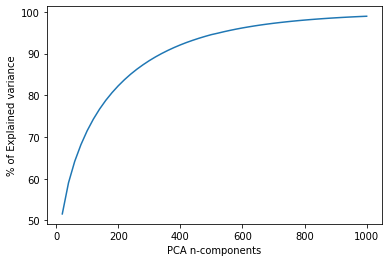

In [7]:
plt.plot(n_components, 100 * np.array(pca_exp_var))
plt.xlabel('PCA n-components')
plt.ylabel('% of Explained variance')
pass

### Exporting PCA values at 80% and 90% to CSV files

In [8]:
mdf_clue_nodata = mdf_clue.drop(columns=l12000_cols)
mdf_clue_dict = {}

for n in [170, 340, 1000]:
    # Compute PCA
    pca_obj = PCA(n_components=n)
    pca_vals = pca_obj.fit_transform(l12000_vals)
    percent_exp_var = int(np.round(100 * pca_obj.explained_variance_ratio_.sum()))
    
    pca_name = f'{CLUE_DIR}{CLUE_NAME}_PCA-{n}_exp-var-{percent_exp_var}.csv'
    pca_df = pd.DataFrame({f'value_{ii}': pca_vals[:, ii] for ii in range(n)})
    new_mdf = pd.concat([mdf_clue_nodata, pca_df], axis=1)
    new_mdf.to_csv(pca_name, index=False)
    print('Saved file: ', pca_name)
    
    mdf_clue_dict[n] = new_mdf
    
    

Saved file:  data/clue/_A375_6H_PCA-170_exp-var-80.csv
Saved file:  data/clue/_A375_6H_PCA-340_exp-var-90.csv
Saved file:  data/clue/_A375_6H_PCA-1000_exp-var-99.csv


## Analyzing the projection data
### Normalizing each row

In [9]:
mdf_clue_dict_norm = {}

for key, data in mdf_clue_dict.items():
    
    data_cols = [f'value_{ii}' for ii in range(key)]
    df_nodata = data.drop(columns=data_cols)
    vals = deepcopy(data[data_cols].values)
    mu = np.mean(vals, axis=0, keepdims=True)
    std = np.std(vals, axis=0, keepdims=True)
    vals_norm = (vals - mu) / std
    
    df_norm = pd.DataFrame({f'value_{ii}': vals_norm[:, ii] for ii in range(key)})
    new_mdf = pd.concat([df_nodata, df_norm], axis=1)
    mdf_clue_dict_norm[key] = new_mdf


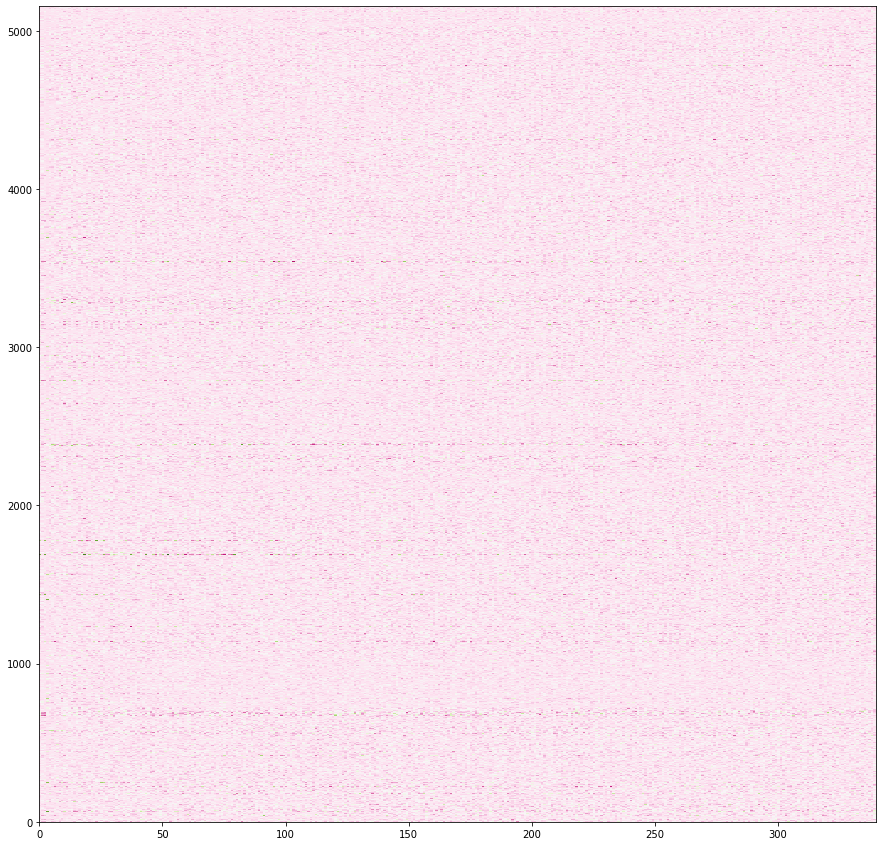

In [11]:
data_340 = mdf_clue_dict_norm[340]
vals_340_norm = data_340[[f'value_{ii}' for ii in range(340)]].values

plt.figure(figsize=(15, 15))
plt.pcolor(vals_340_norm, cmap='PiYG')


## Project the molecular space

In [12]:
fp_trans = FingerprintsTransformer(kind='rdkit', length=2048)
ms = MolecularSpace(mdf_clue_dict_norm[170],fp_transformer=fp_trans, name='PCA-170', 
                    n_jobs=1, sampling_limit=3000)

Done checking for SMILES validity. 
3000 valid smiles, 0 invalid smiles.


### TSNE

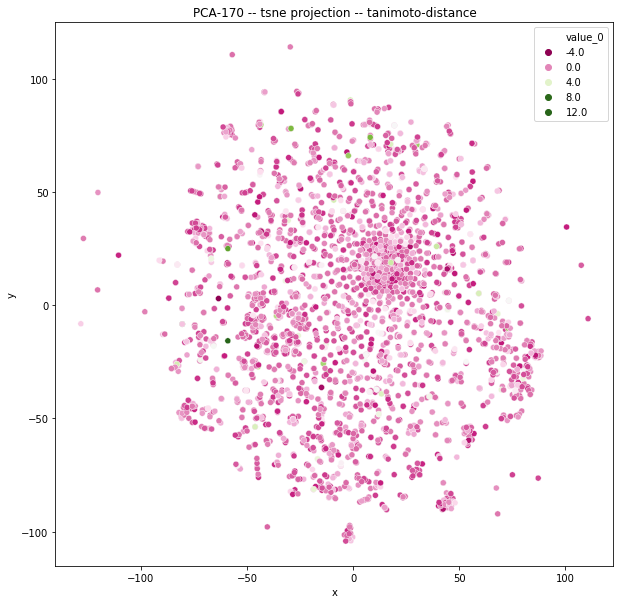

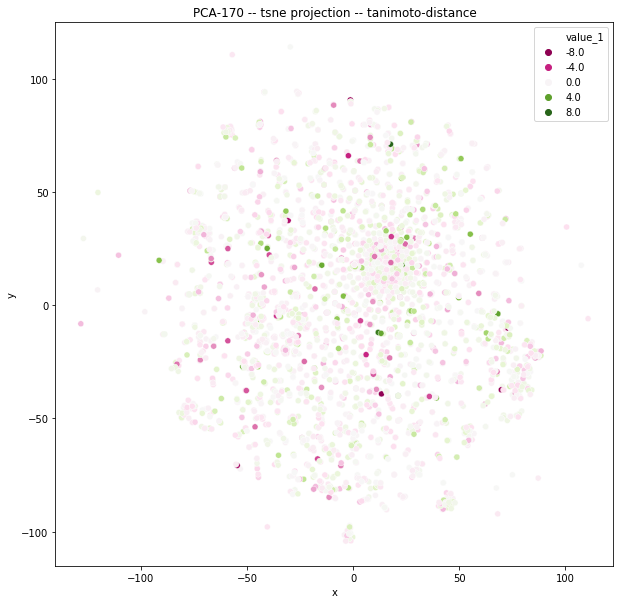

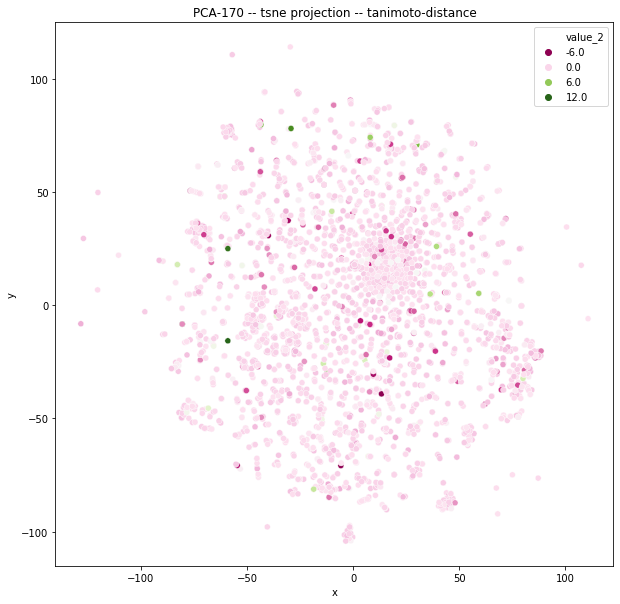

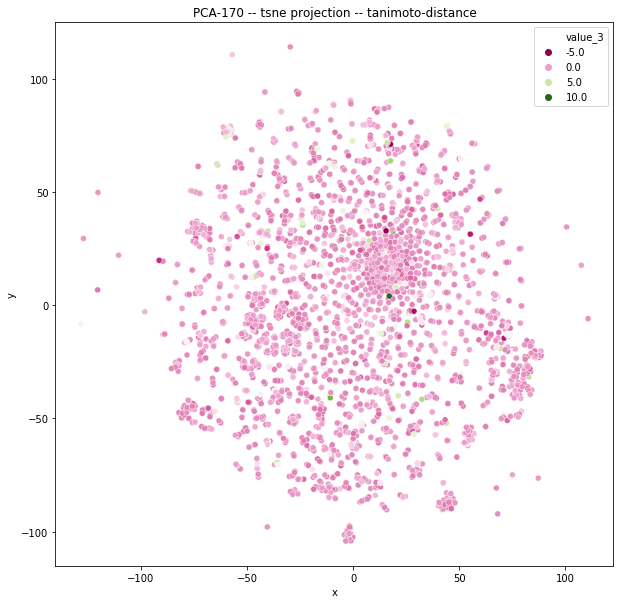

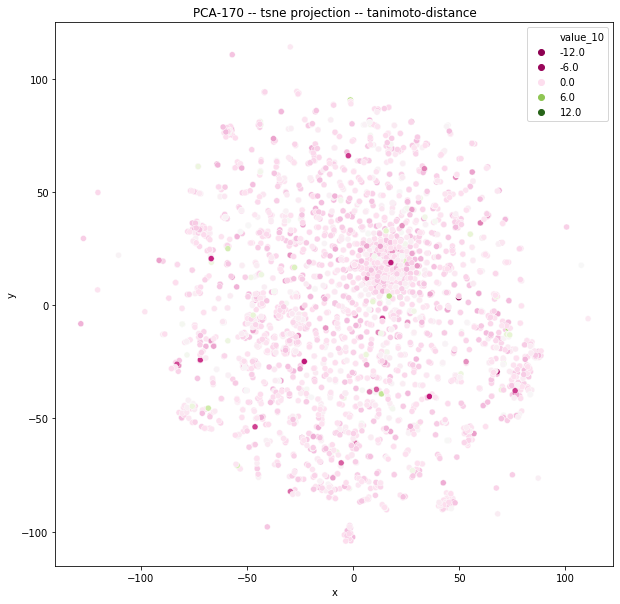

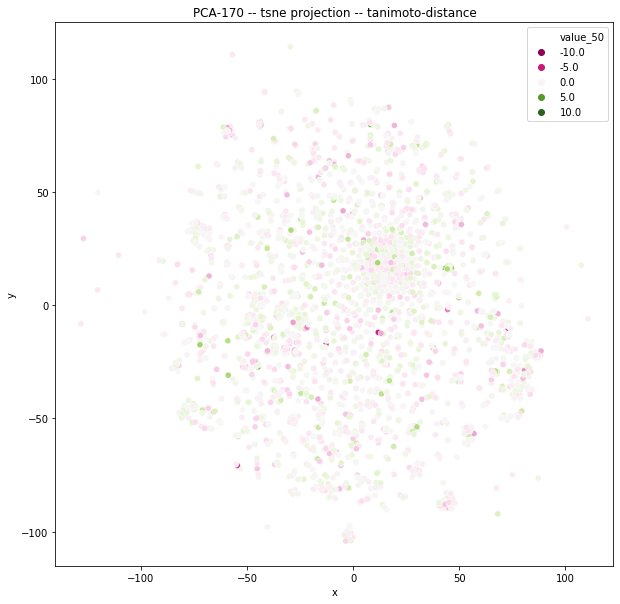

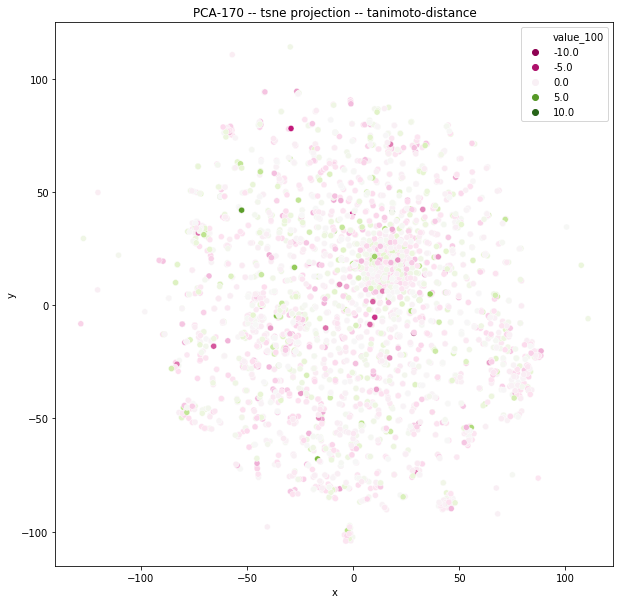

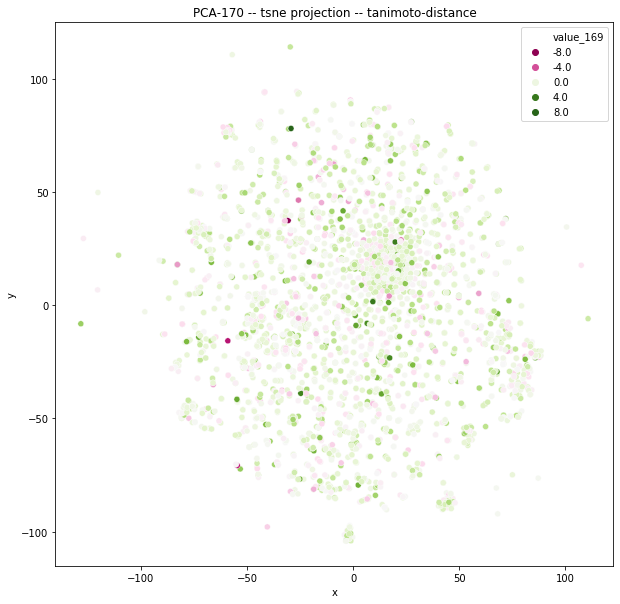

(array([[-36.34362  , -18.492046 ],
        [-17.54964  ,  12.60064  ],
        [-86.86846  ,   3.128321 ],
        ...,
        [ 52.42238  , -60.69197  ],
        [ 28.78172  , -12.00514  ],
        [  1.3832617, -36.76922  ]], dtype=float32),
 TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
      method='exact', metric='precomputed', min_grad_norm=1e-07, n_components=2,
      n_iter=1000, n_iter_without_progress=300, n_jobs=None, perplexity=50,
      random_state=None, verbose=0),
  <matplotlib.axes._subplots.AxesSubplot at 0x7f804d26e630>])

In [13]:
pca_ids = [0, 1, 2, 3, 10, 50, 100, 169]
score_cols = [f'value_{pca_id}' for pca_id in pca_ids]
ms.visualize_projection(projection_method='tsne', dist_method='tanimoto-distance', 
                        score_col=score_cols, figsize=(10, 10), scatter_kwargs={'palette': 'PiYG'})


### PCA

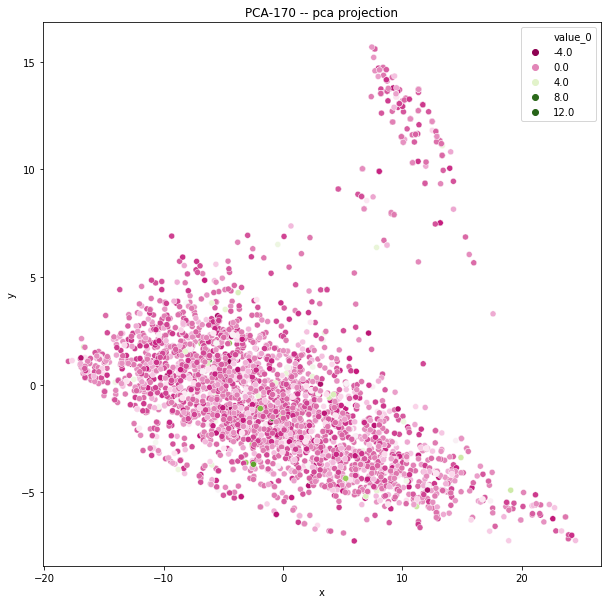

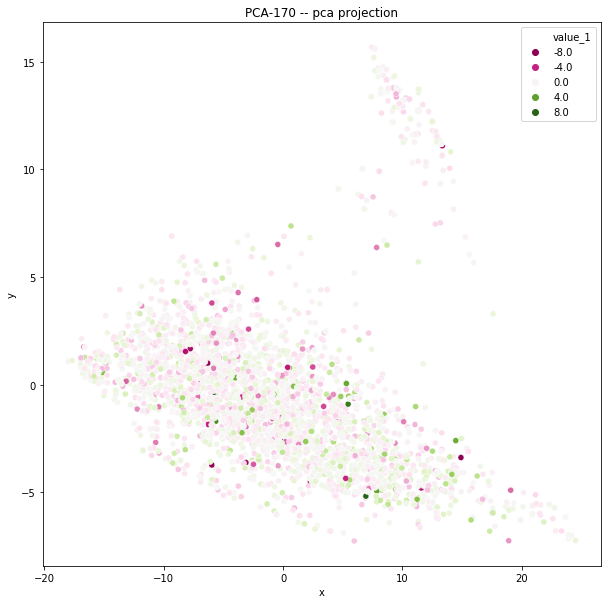

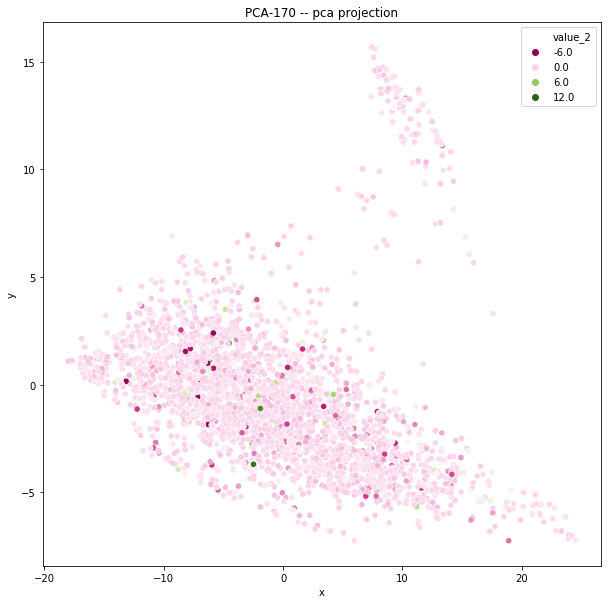

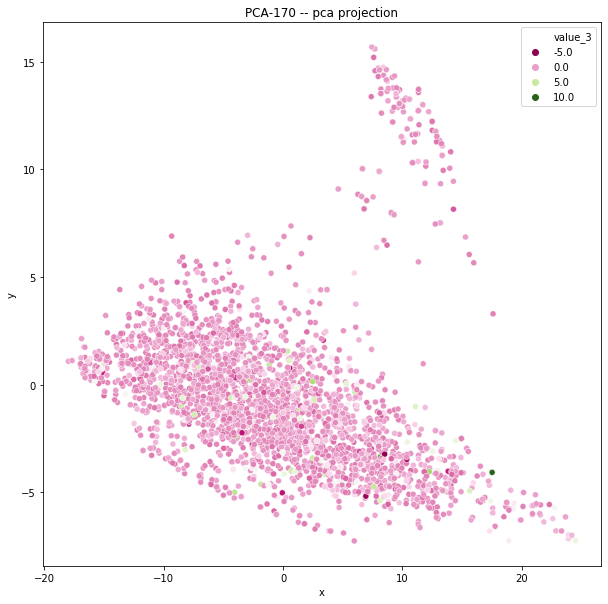

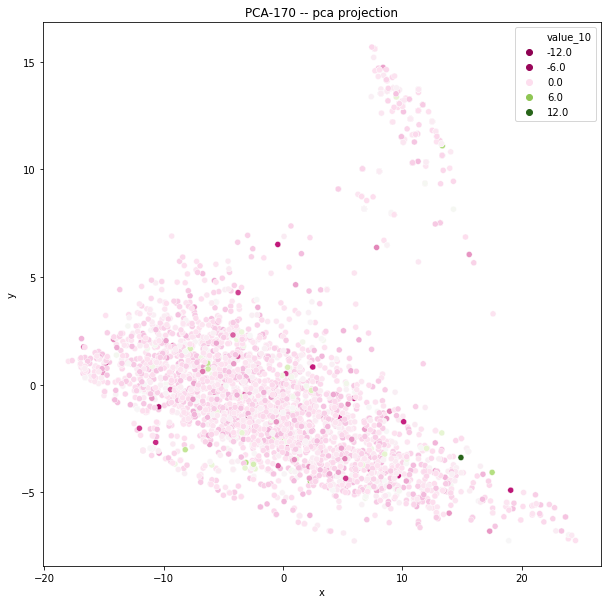

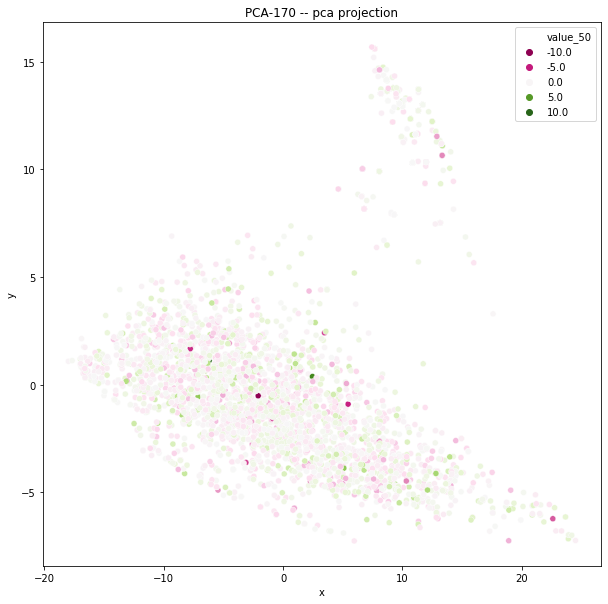

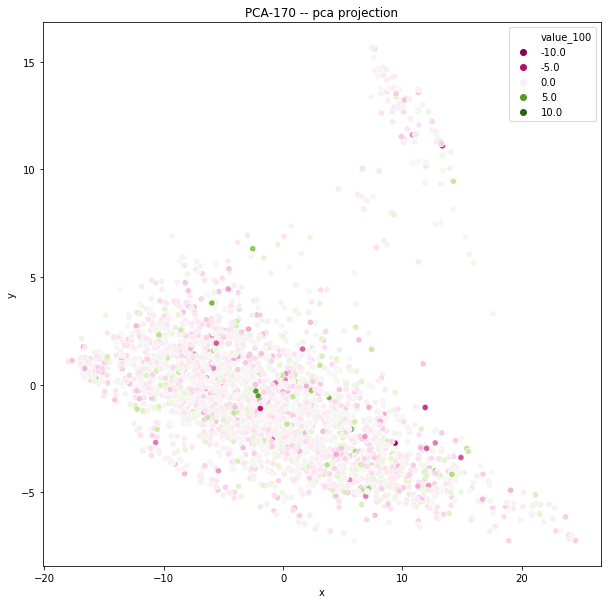

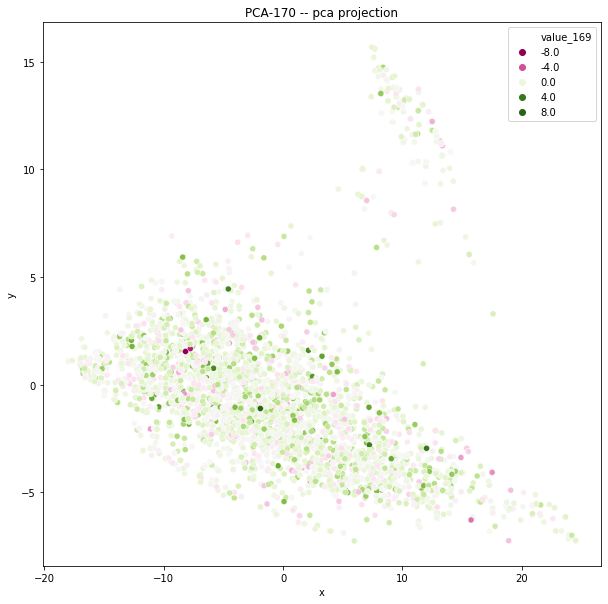

(array([[  8.65379019,  14.16729322],
        [ -8.82758707,   0.17436101],
        [-12.75502521,   0.95672192],
        ...,
        [-17.68443253,   1.11972798],
        [  9.13225194,  -2.65170909],
        [ -3.9948248 ,   1.39418029]]),
 PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
  <matplotlib.axes._subplots.AxesSubplot at 0x7f804cf77630>])

In [14]:
pca_ids = [0, 1, 2, 3, 10, 50, 100, 169]
score_cols = [f'value_{pca_id}' for pca_id in pca_ids]
ms.visualize_projection(projection_method='pca', dist_method='tanimoto-distance', 
                        score_col=score_cols, figsize=(10, 10), scatter_kwargs={'palette': 'PiYG'})
